In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Hp/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

KeyboardInterrupt: 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)

cur = db.cursor()

### All unique cities where customers are located.

In [6]:
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

### Number of orders placed in 2017

In [7]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)
data = cur.fetchall()
data[0][0]

586313

### Total sales per category

In [10]:
query = """select products.product_category category, sum(payments.payment_value) sales from products join order_items
on products.product_id = order_items.product_id join payments on payments.order_id = order_items.order_id group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df 

,0,1
0,perfumery,4.864691e+08
1,Furniture Decoration,1.372969e+09
2,telephony,4.674068e+08
3,bed table bath,1.644052e+09
4,automotive,8.182026e+08
...,...,...
69,cds music dvds,1.151453e+06
70,La Cuisine,2.796989e+06
71,Fashion Children's Clothing,7.542432e+05
72,PC Gamer,2.087453e+06


### Percentage of orders paid in installment

In [15]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

### Number of customers from each state

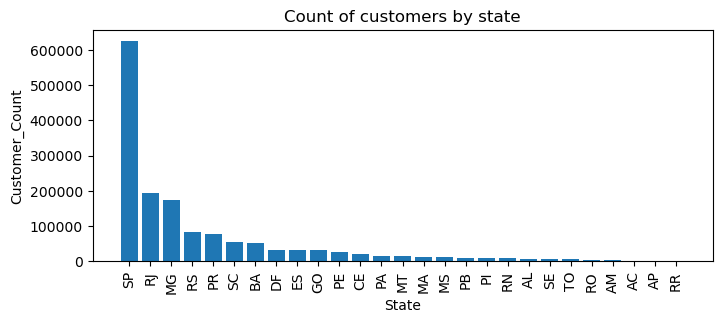

In [ ]:
query = """select customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['State', 'Customer_count'])
df = df.sort_values(by = "Customer_count", ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df['State'],df['Customer_count'])
plt.xticks(rotation = 90)
plt.xlabel("State")
plt.ylabel("Customer_Count")
plt.title("Count of customers by state")
plt.show()

### Number of orders per month in 2018

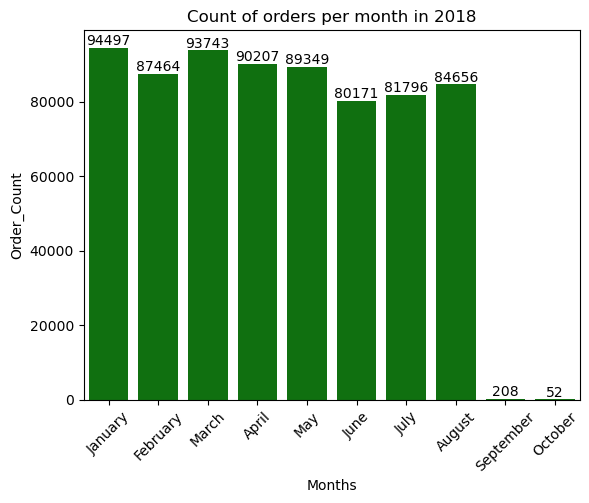

In [ ]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count from orders where
year(order_purchase_timestamp) = 2018 group by months"""
cur.execute(query)
data = cur.fetchall() 
data =data.df(data, columns)
df = pd.DataFrame(data, columns=['Months', 'Order_Count'])
o = ["January","February","March","April","May","June","July","August","September","October",]
ax = sns.barplot(x = df["Months"], y = df["Order_Count"], data = df, order = o,color='green')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders per month in 2018")
plt.show()

### Number of products per order, group by customer city.

In [ ]:
query = """with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count from orders join order_items on orders.order_id = order_items.order_id
group by order_id, customer_id)
select customers.customer_city, avg(count_per_order.order_count) average_order from customers join count_per_order on
customers.customer_id = count_per_order.customer_id group by customers.customer_city order by average_order desc join select
orders from customers join orders to orders.customer_id = customers.customer_id where join with 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer City", "Average products per order"])
df 

,Customer City,Average products per order
0,padre carvalho,728.0000
1,celso ramos,676.0000
2,datas,624.0000
3,candido godoi,624.0000
4,matias olimpio,520.0000
...,...,...
4105,sao mamede,104.0000
4106,sambaiba,104.0000
4107,japaratuba,104.0000
4108,tuiuti,104.0000


### Percentage of total revenue contributed by each product category.

In [42]:
query = """select products.product_category category, round((sum(payments.payment_value)/(select sum(payment_value) from payments)) * 100,2)
sales_precentage from order_items join products
on order_items.product_id = products.product_id join 
payments on payments.order_id = order_items.order_id group by category order by sales_percentage desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Percentage Distribution'])
df.head(5)

ProgrammingError: 1054 (42S22): Unknown column 'sales_percentage' in 'order clause'